# Match crime addresses to the address database

Have a database of addresses.  Seems very similar to what might be available from OpenStreetMap.

Idea is to match the _names_ of the "block" from the crime data to addresses.  Then somehow use intelligently the address points: probably to make an "envelope" of area where events are, in reality, likely to have occurred.

Turns out the data is quite messy (of course!)  There are some fairly simple differences, like "ST" vs "STREET".  Some common names might have two (or more) distinct locations, so you need to "cluster" them.
- A lot of "blocks" actually don't have any addresses associated with them!


## Load address data

In [1]:
import os, zipfile, csv

In [2]:
#datadir = os.path.join("..", "..", "..", "..", "Data")
datadir = os.path.join("/media", "disk", "Data")
filename = os.path.join(datadir, "openaddr-collected-us_midwest.zip")
zf = zipfile.ZipFile(filename)
import pandas as pd
with zf.open('us/il/cook.csv') as f:
    addresses = pd.read_csv(f, low_memory=False)

In [3]:
addresses = addresses[addresses.STREET.notnull()].copy()
addresses.head()

,LON,LAT,NUMBER,STREET,UNIT,CITY,DISTRICT,REGION,POSTCODE,ID,HASH
0,-88.190438,42.074161,4589,WEST HIGGINS ROAD,NaN,Hoffman Estates,NaN,NaN,60192.0,NaN,7e424765c7c8f0c0
1,-88.135805,42.153453,125,SOUTH HOUGH STREET,NaN,Barrington,NaN,NaN,60010.0,NaN,099b736c8dfa0f1f
2,-88.122677,42.147437,104,QUEENS COVE,NaN,Barrington,NaN,NaN,60010.0,NaN,a924636168daf4ed
3,-88.122906,42.092878,1732,WEST ALGONQUIN ROAD,NaN,Hoffman Estates,NaN,NaN,60120.0,NaN,dc1563d64be36394
4,-88.123053,42.092878,1736,WEST ALGONQUIN ROAD,NaN,Hoffman Estates,NaN,NaN,60120.0,NaN,9efa31fc81d103e7


## Load crime data

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import os, lzma, csv, bz2, io, collections, pickle
import pyproj
import tilemapbase
import shapely.geometry

import open_cp.sources.chicago

In [5]:
data_dir = os.path.join("/media", "disk", "Data")
#data_dir = os.path.join("..", "..", "..", "..", "Data")
#os.listdir(data_dir)
filename = os.path.join(data_dir, "chicago_all.csv.xz")

In [6]:
with lzma.open(filename, "rt", encoding="utf8") as f:
    reader = csv.reader(f)
    header = next(reader)
    out = collections.defaultdict(list)
    data = []
    for row in reader:
        if row[15] == "":
            continue
        year = int(row[17])
        if year <= 2001:
            continue
        block, x, y = row[3], float(row[15]), float(row[16])
        x /= open_cp.sources.chicago._FEET_IN_METERS
        y /= open_cp.sources.chicago._FEET_IN_METERS
        if x < 10 or y < 10:
            continue
        out[block].append((x,y))
        data.append((block, x, y, row[5], row[6], row[7]))
out = {k : np.asarray(out[k]) for k in out}
len(out)

51625

In [7]:
proj = pyproj.Proj({"init":"epsg:3528"})

import warnings

def mywarning(message, category, filename, lineno, file=None, line=None):
    raise Exception(message)

warnings.showwarning = mywarning

## Match to address data

Various methods to try to "normalise" street names and extract/convert address numbers.

In [8]:
def redact(street):
    if pd.isnull(street):
        return "XX"
    return street[:-2] + "XX"

In [9]:
prefix = {"S":"SOUTH", "N":"NORTH", "E":"EAST", "W":"WEST"}
postfix = {"AVE":"AVENUE", "ST":"STREET", "PL":"PLACE", "BLVD":"BOULEVARD",
          "RD":"ROAD", "DR":"DRIVE", "CT":"COURT"}
replaces = {" DR ":" DOCTOR ", " ST ":" SAINT ", " MC VICKER ":" MCVICKER "}
rename = {"N BROADWAY":"NORTH BROADWAY STREET", "S EAST VIEW PARK":"SOUTH EAST VIEW PARK STREET"}

def normalise(block):
    i = block.find(" ")
    num, street = block[:i], block[i+1:]
    
    if street in rename:
        street = rename[street]
    
    for f, t in prefix.items():
        if street.startswith(f+" "):
            street = t + street[len(f):]
    for f, t in postfix.items():
        if street.endswith(" "+f):
            street = street[:-len(f)] + t
    for f, t in replaces.items():
        street = street.replace(f, t)        
        
    while num[0] == "0":
        num = num[1:] 
    if num == "X":
        num = "XX"
    
    return num, street

assert normalise("008XX S LOOMIS BLVD") == ("8XX", "SOUTH LOOMIS BOULEVARD")

Some clustering routines.

In [22]:
import scipy.cluster
import matplotlib.patches

def cluster(xcs, ycs, k):
    """Use the k-means algorithm from `scipy.cluster` to try to cluster the points
    into `k` clusters.  Returns the cluster centres, `assignment` a list the same
    length as `xcs` giving which cluster each point is assigned to, and `radii`,
    a list of radii around each centre which contains all the points assigned
    to that cluster."""
    addpts = np.asarray([xcs, ycs]).T
    centres, _ = scipy.cluster.vq.kmeans(addpts, k)
    assignment = []
    for x, y in zip(xcs, ycs):
        d = (centres - np.asarray([x,y]))**2
        d = np.sqrt(np.sum(d, axis=1))
        assignment.append( np.argmin(d) )
    assignment = np.asarray(assignment, dtype=np.int)

    radii = []
    for i, (x,y) in enumerate(centres):
        xx, yy = xcs[assignment == i], ycs[assignment == i]
        d = np.sqrt( (xx-x)**2 + (yy-y)**2 )
        radii.append( np.max(d) )
    return centres, assignment, radii

def natural_cluster(xcs, ycs):
    """Attemp to "naturally cluster" the points.  Returns the number of clusters."""
    sr = []
    for k in range(1, 10):
        _, _, rr = cluster(xcs, ycs, k)
        rad = max(1e-10, sum(rr))
        sr.append(rad)
        
    if sr[0] < 500:
        return 1
        
    ratios = np.asarray([a/b for a,b in zip(sr, sr[1:])])
    max_ratio_index = np.argmax(ratios)
    max_ratio = ratios[max_ratio_index]
    if max_ratio > 10:
        return max_ratio_index + 2
    return 1

We now use these routines.
- For each block (keys of `out`) we normalise the name, and try to find all address of that name.
- Look at each location of selected addresses, and try to cluster
- If more than 1 cluster, then select the cluster closest to the event locations
- Plot the result.

In [25]:
known_missing = {"XX W OHARE ST", "E BROWNING AVE", "02XX N HALSTED ST",
                "012XX S CLARK ST", "114XX S COTTAGE GROVE AVE", "0000X N KENTON AVE",
                "009XX E 71ST ST"}

class KnownNoAddress(Exception):
    pass

def known_no_address(block):
    """Raise a `KnownNoAddress` if we expect a problem."""
    for x in known_missing:
        if block.endswith(x):
            raise KnownNoAddress()

In [26]:
keys = list(out)

'053XX N CLARK ST' -> '53XX' / 'NORTH CLARK STREET'


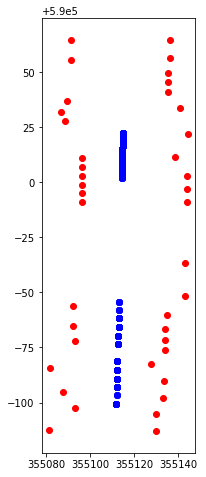

In [27]:
block = keys[50]
known_no_address(block)
num, street = normalise(block)
print("'{}' -> '{}' / '{}'".format(block, num, street))
ad = addresses[addresses.STREET == street]
assert len(ad) > 0
adst = ad[ad.NUMBER.map(redact) == num]
assert len(adst) > 0
xcs = adst.LON.as_matrix().copy()
ycs = adst.LAT.as_matrix().copy()
xcs, ycs = proj(xcs, ycs)

clusters = natural_cluster(xcs, ycs)
if clusters > 1:
    centres, assignment, _ = cluster(xcs, ycs, clusters)
    dists = [np.max(np.sqrt(np.sum((out[block] - np.asarray([x,y])) ** 2, axis=1)))
             for (x, y) in centres ]
    i = np.argmin(dists)
    m = (assignment == i)
    xcs, ycs = xcs[m], ycs[m]
    print("Selected cluster {} from {}".format(i, clusters))

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(*out[block].T, color="blue")
ax.scatter(xcs, ycs, color="red")
ax.set_aspect(1)
None

Now try to do the same, but systematically.

In [28]:
for i, block in enumerate(keys):
    try:
        known_no_address(block)
    except KnownNoAddress:
        continue
    num, street = normalise(block)
    ad = addresses[addresses.STREET == street]
    assert len(ad) > 0
    adst = ad[ad.NUMBER.map(redact) == num]
    if len(adst) == 0:
        print("'{}' -> '{}' / '{}'".format(block, num, street))
        raise AssertionError()
    xcs = adst.LON.as_matrix().copy()
    ycs = adst.LAT.as_matrix().copy()
    xcs, ycs = proj(xcs, ycs)

    clusters = natural_cluster(xcs, ycs)
    if clusters > 1:
        centres, assignment, _ = cluster(xcs, ycs, clusters)
        dists = [np.max(np.sqrt(np.sum((out[block] - np.asarray([x,y])) ** 2, axis=1)))
                 for (x, y) in centres ]
        i = np.argmin(dists)
        m = (assignment == i)
        xcs, ycs = xcs[m], ycs[m]
        print("Selected cluster {} from {}".format(i, clusters))


Selected cluster 1 from 2
Selected cluster 0 from 2
Selected cluster 1 from 2
Selected cluster 1 from 2
Selected cluster 1 from 2
'040XX W 19TH ST' -> '40XX' / 'WEST 19TH STREET'


AssertionError: 

In [29]:
block, num, street

('040XX W 19TH ST', '40XX', 'WEST 19TH STREET')

In [34]:
ad

,LON,LAT,NUMBER,STREET,UNIT,CITY,DISTRICT,REGION,POSTCODE,ID,HASH
581639,-87.856051,41.853551,1919,WEST 19TH STREET,NaN,Broadview,NaN,NaN,60155.0,NaN,5dbeaacf42bcbe54
583370,-87.856654,41.853553,2001,WEST 19TH STREET,NaN,Broadview,NaN,NaN,60155.0,NaN,44a1ac6e477e93b9
613015,-87.844647,41.853836,1005,WEST 19TH STREET,NaN,Broadview,NaN,NaN,60155.0,NaN,9afde4faba01f9fc
613030,-87.844021,41.853660,921,WEST 19TH STREET,NaN,Broadview,NaN,NaN,60155.0,NaN,e1c7b0a17b624969
613068,-87.844334,41.853746,1003,WEST 19TH STREET,NaN,Broadview,NaN,NaN,60155.0,NaN,5224e428112a1880
613483,-87.843699,41.853571,915,WEST 19TH STREET,NaN,Broadview,NaN,NaN,60155.0,NaN,d97fc203d459a480
622299,-87.692088,41.855363,2643,WEST 19TH STREET,NaN,Chicago,NaN,NaN,60608.0,NaN,618e988b209699b6
633514,-87.702475,41.855222,3055,WEST 19TH STREET,NaN,Chicago,NaN,NaN,60623.0,NaN,7e5d22688de75614
640031,-87.721908,41.855193,3848,WEST 19TH STREET,NaN,Chicago,NaN,NaN,60623.0,NaN,032cb0f9217c3d41
644151,-87.700910,41.855236,3011,WEST 19TH STREET,NaN,Chicago,NaN,NaN,60623.0,NaN,ce431f17eccd4323


In this particular case, what's gone wrong is that there are no known addresses matching the 4000 block of this street.

Visualise this.

- Blue points are the points from the current block, here '040XX W 19TH ST'
- Red points are all the address locations from the `ad` data frame, as above.

In [32]:
alladd = []
for x, y in zip(addresses.LON, addresses.LAT):
    alladd.append( tilemapbase.project(x, y) )
alladd = np.asarray(alladd)
alladd.shape

(1333456, 2)

040XX W 19TH ST (-87.726061483229998, 41.85499738463528)


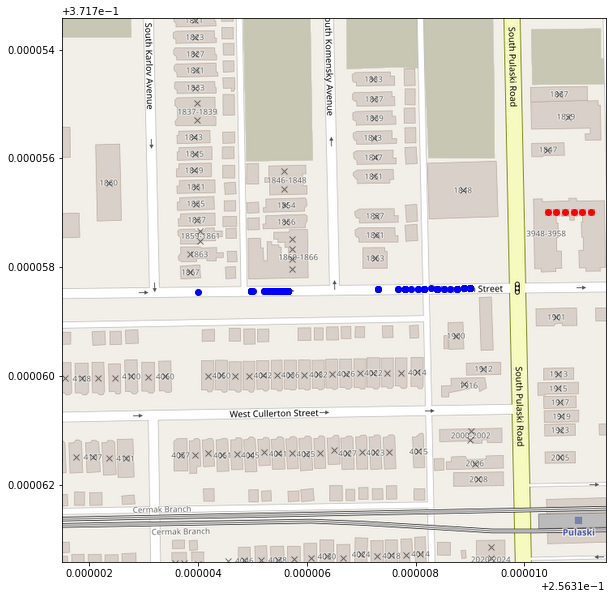

In [35]:
fig, ax = plt.subplots(figsize=(10,10))

pts = []
for x, y in out[block]:
    x, y = tilemapbase.project(*proj(x, y, inverse=True))
    pts.append((x, y))
pts = np.asarray(pts)
ax.scatter(*pts.T, color="blue")
ax.scatter(*alladd.T, color="black", marker="x", linewidth=1, alpha=0.5)
adpts = []
for x, y in zip(ad.LON, ad.LAT):
    adpts.append( tilemapbase.project(x, y) )
adpts = np.asarray(adpts)
ax.scatter(*adpts.T, color="red")

x = np.mean(pts[:,0])
y = np.mean(pts[:,1])
print(block, tilemapbase.mapping.to_lonlat(x, y))

ex = tilemapbase.Extent.from_centre(x, y, xsize=0.00001)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=400)
plotter.plot(ax)

Same, but more zoomed out.

040XX W 19TH ST (-87.726061483229998, 41.85499738463528)
0.256313996353 0.256536202222
0.371758386073 0.372208019388


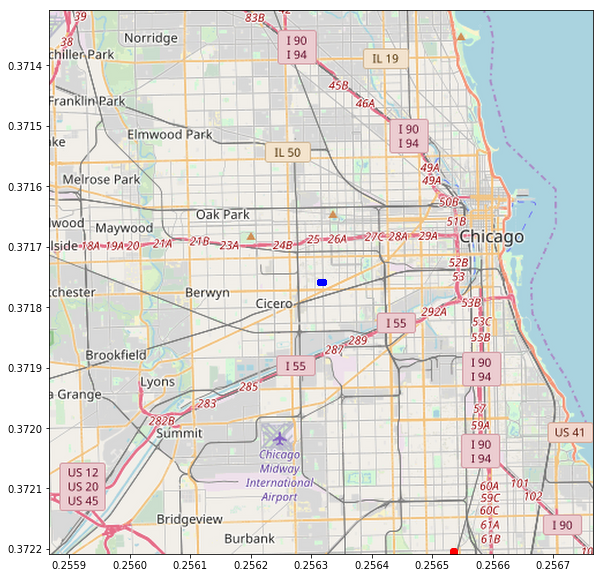

In [21]:
fig, ax = plt.subplots(figsize=(10,10))

pts = []
for x, y in out[block]:
    x, y = tilemapbase.project(*proj(x, y, inverse=True))
    pts.append((x, y))
pts = np.asarray(pts)
ax.scatter(*pts.T, color="blue")

addpts = []
for x, y in zip(xcs, ycs):
    x, y = tilemapbase.project(*proj(x, y, inverse=True))
    addpts.append((x, y))
addpts = np.asarray(addpts)
ax.scatter(*addpts.T, color="red")

x = np.mean(pts[:,0])
y = np.mean(pts[:,1])
print(block, tilemapbase.mapping.to_lonlat(x, y))
xmin = min(np.min(pts[:,0]), np.min(addpts[:,0]))
xmax = max(np.max(pts[:,0]), np.max(addpts[:,0]))
print(xmin, xmax)
ymin = min(np.min(pts[:,1]), np.min(addpts[:,1]))
ymax = max(np.max(pts[:,1]), np.max(addpts[:,1]))
print(ymin, ymax)
width, height = xmax - xmin, ymax - ymin
if width > height:
    ex = tilemapbase.Extent.from_centre(x, y, xsize=width*2)
else:
    ex = tilemapbase.Extent.from_centre(x, y, ysize=height*2)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=400)
plotter.plot(ax)